# Acoustic SoftDTW-FWI parametrized in velocity using only refractions

This notebook performs acoustic FWI parametrized in velocity using only refracted arrivals. It is mostly aimed at showcasing the SoftDTW objective function in ``devitofwi.loss.dtw.SoftDTW`` implemented in the tslearn library with PyTorch.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from devito import configuration
from itertools import chain
from pylops.basicoperators import Diagonal#, Identity
import torch

# from tqdm.notebook import tqdm
# from examples.seismic import AcquisitionGeometry, Model, Receiver
# from examples.seismic import plot_velocity, plot_perturbation
# from examples.seismic.acoustic import AcousticWaveSolver
# from examples.seismic import plot_shotrecord

# from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.preproc.masking import TimeSpaceMasking
# from devitofwi.loss.xcorr import XCorrTorch
from devitofwi.loss.dtw import SoftDTW
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP
from devitofwi.fwi.acoustic import AcousticFWI2D

configuration['log-level'] = 'ERROR'

Using matplotlib backend: module://matplotlib_inline.backend_inline


/home/alfarhmy/Documents/Github/Devito-fwi/devitofwi/waveengine/acoustic.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/alfarhmy/miniconda3/envs/devitofwi_gpu/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters (in km, s, and Hz units)
par = {'nx':601,   'dx':0.015,    'ox':0,
       'nz':221,   'dz':0.015,    'oz':0,
       'ns':20,    'ds':0.300,    'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,    'or':0,   'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':7,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

# Time-space mask parameters
vwater = 1.5
toff = 0.35

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

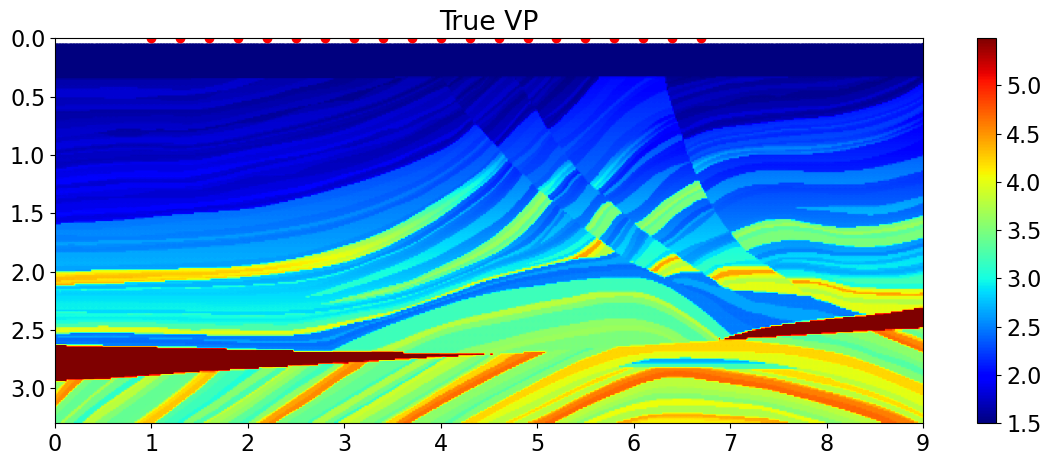

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(221, 601).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

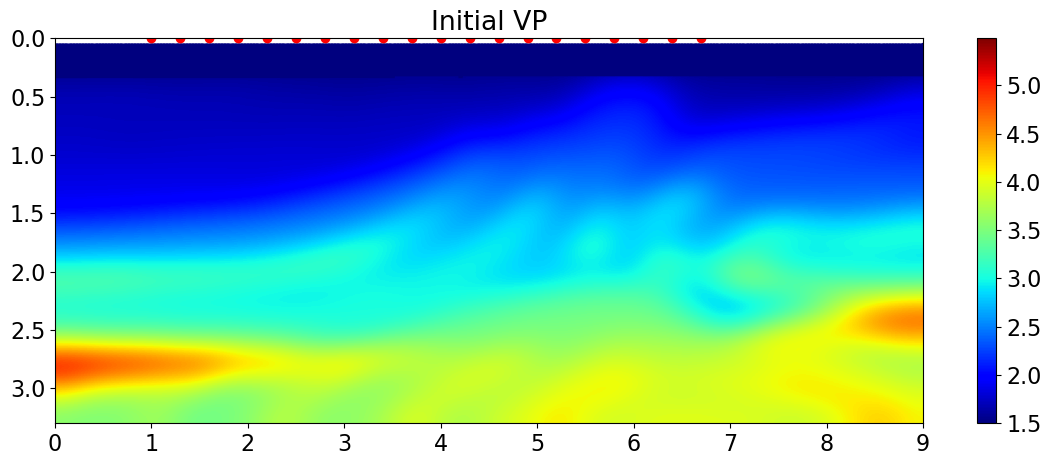

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
# msk = msk[250:450, :100]
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
# Define modelling engine
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl)

# Create model and geometry to extract useful information to define the filtering object
model, geometry = amod.model_and_geometry()

In [9]:
# Model data
dobs, dtobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

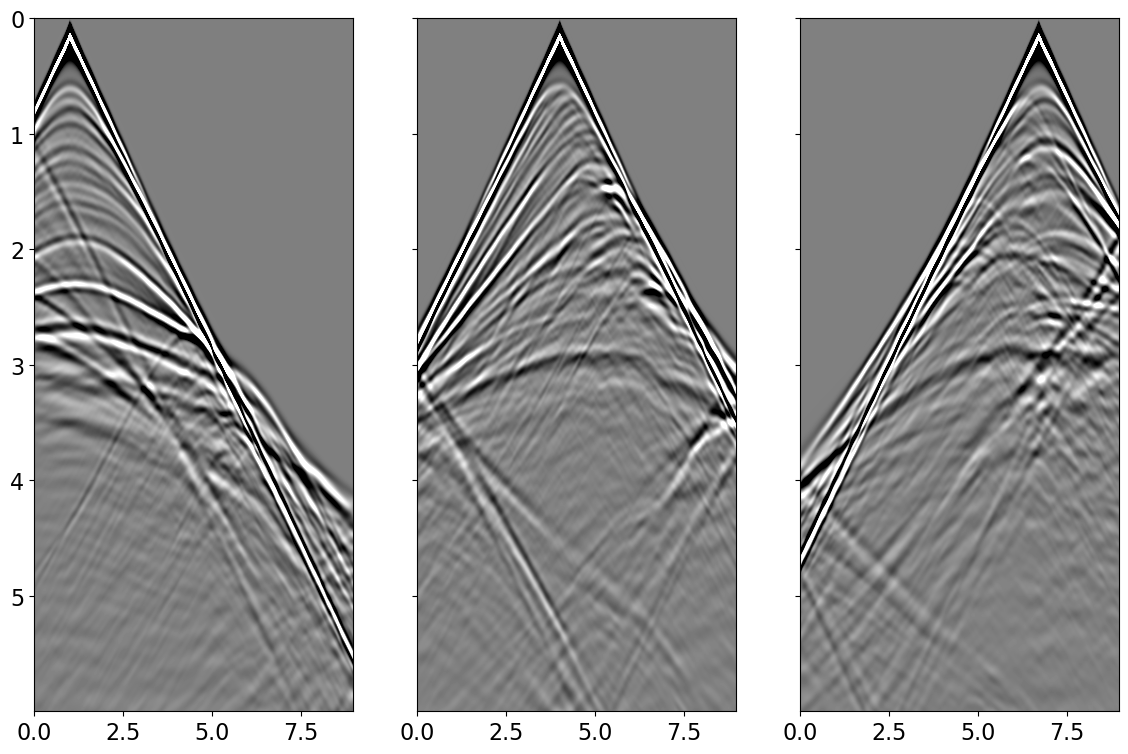

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)

## Mask creation

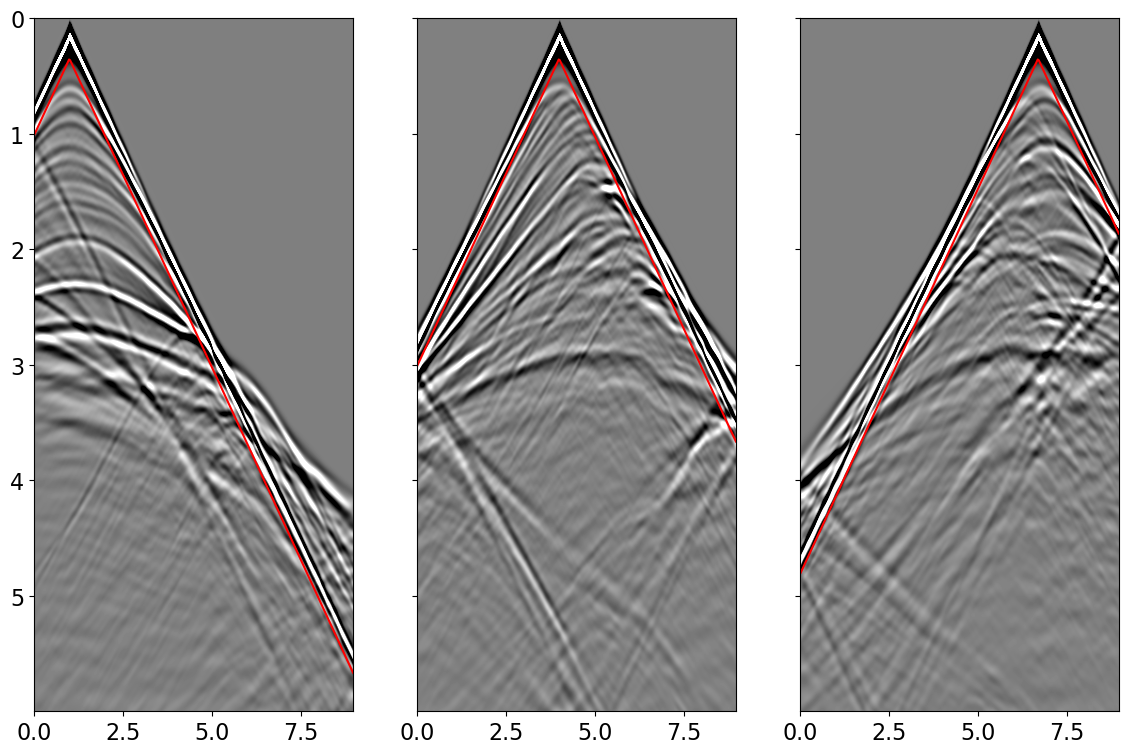

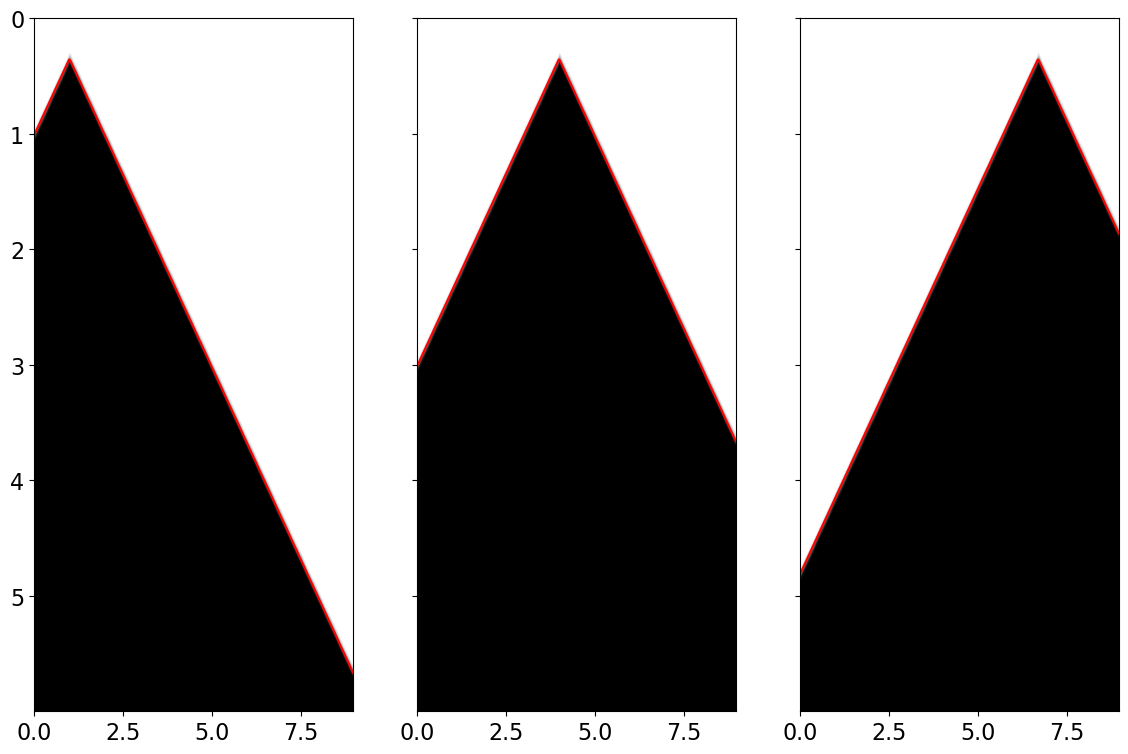

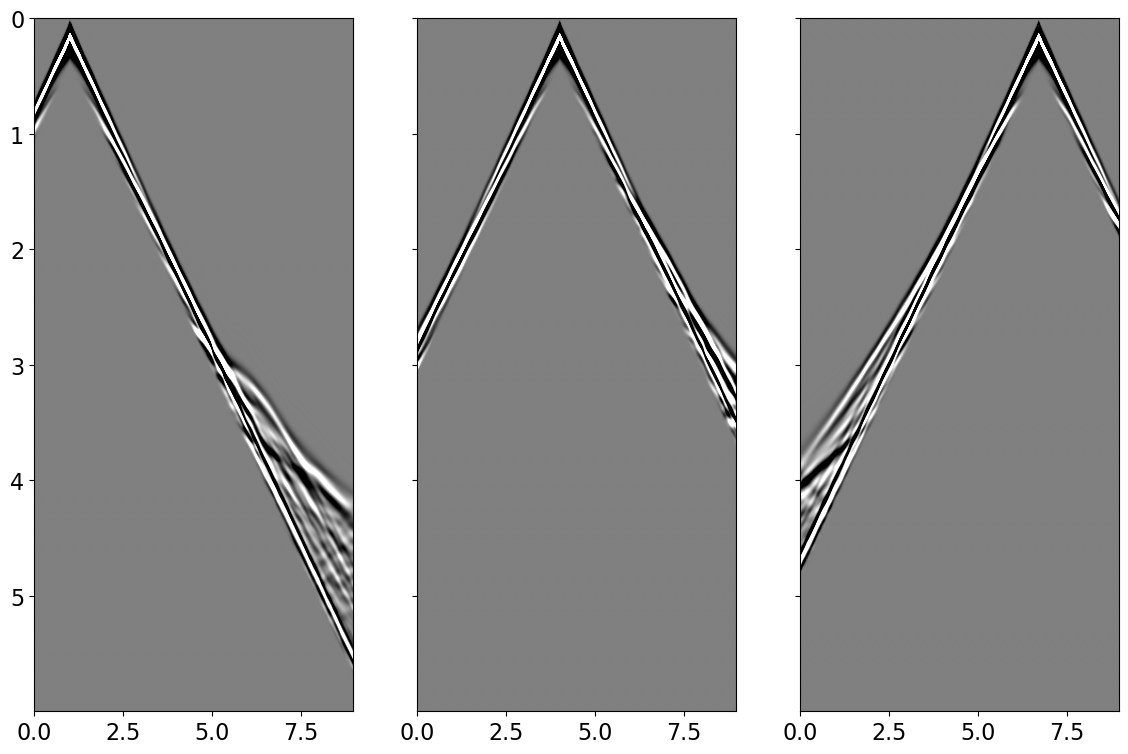

In [11]:
# Create direct arrival mask
distance = np.sqrt((x_s[:, 0][:, None]-x_r[:, 0][None, :])**2 + (x_s[:, 1][:, None]-x_r[:, 1][None, :])**2)
directtime = distance / vwater
tsmask = TimeSpaceMasking(directtime, geometry.nt, geometry.dt, toff, nsmooth=50)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=0, vmax=1)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot] * tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax);

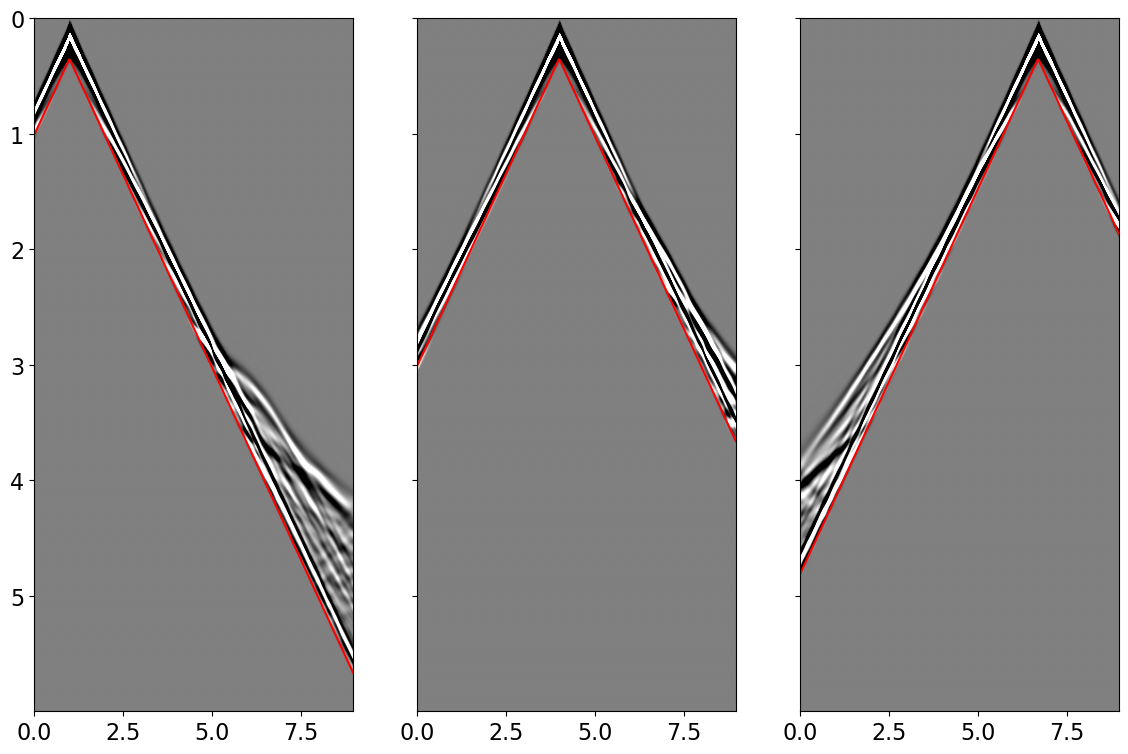

In [12]:
# Mask observed data to have direct arrival and refractions
TSmaskop = [Diagonal(tsmask.mask[isrc].T.ravel()) for isrc in range(par['ns'])]
dobs_masked = np.hstack([(TSmaskop[isrc] @ dobs[isrc].ravel())[None, :] for isrc in range(par['ns'])])
dobs_masked = dobs_masked.reshape(par['ns'], geometry.nt, par['nr'])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], directtime[ishot] + toff, 'r')

## Inversion with L-BFGS

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76172D+02    |proj g|=  1.05561D+00


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  3.77684D+02    |proj g|=  9.16976D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  1.96306D+02    |proj g|=  5.20243D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  1.38681D+02    |proj g|=  3.72705D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  8.77869D+01    |proj g|=  3.93083D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  7.08362D+01    |proj g|=  2.30767D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  6.30707D+01    |proj g|=  9.46501D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  5.74166D+01    |proj g|=  7.44431D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  4.86812D+01    |proj g|=  1.29147D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  4.25727D+01    |proj g|=  9.37380D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  3.73060D+01    |proj g|=  8.66337D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  3.32052D+01    |proj g|=  3.99400D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  3.00298D+01    |proj g|=  4.60801D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  2.76778D+01    |proj g|=  9.00486D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  2.55741D+01    |proj g|=  7.94378D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  2.31613D+01    |proj g|=  5.62823D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  2.18281D+01    |proj g|=  7.09354D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  2.05582D+01    |proj g|=  4.26259D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  1.92221D+01    |proj g|=  2.97725D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  1.82228D+01    |proj g|=  3.53832D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  1.70049D+01    |proj g|=  5.21866D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  1.64193D+01    |proj g|=  3.31662D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  1.57671D+01    |proj g|=  2.49908D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  1.47893D+01    |proj g|=  3.49381D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  1.41520D+01    |proj g|=  5.65718D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  1.34431D+01    |proj g|=  3.25518D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  1.26396D+01    |proj g|=  2.81627D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  1.22452D+01    |proj g|=  2.56744D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  1.14729D+01    |proj g|=  5.39539D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  1.10195D+01    |proj g|=  3.01137D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  1.07566D+01    |proj g|=  1.64343D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  1.04208D+01    |proj g|=  1.28775D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  1.00933D+01    |proj g|=  1.56861D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  9.81430D+00    |proj g|=  3.85708D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  9.44429D+00    |proj g|=  2.38427D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  9.13801D+00    |proj g|=  1.25998D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  8.82412D+00    |proj g|=  2.03363D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  8.58474D+00    |proj g|=  2.20479D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  8.35139D+00    |proj g|=  1.58810D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  8.06920D+00    |proj g|=  1.28333D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  7.83077D+00    |proj g|=  2.94808D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  7.62119D+00    |proj g|=  1.70806D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  7.44491D+00    |proj g|=  1.17228D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  7.17287D+00    |proj g|=  2.56925D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  7.01783D+00    |proj g|=  1.82787D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  6.75625D+00    |proj g|=  1.19098D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  6.59931D+00    |proj g|=  2.66147D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  6.41351D+00    |proj g|=  2.09737D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  6.17920D+00    |proj g|=  1.93701D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  6.00799D+00    |proj g|=  1.41132D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  5.85960D+00    |proj g|=  9.59375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     52      1     0     0   9.594D-03   5.860D+00
  F =   5.8596035068965824     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


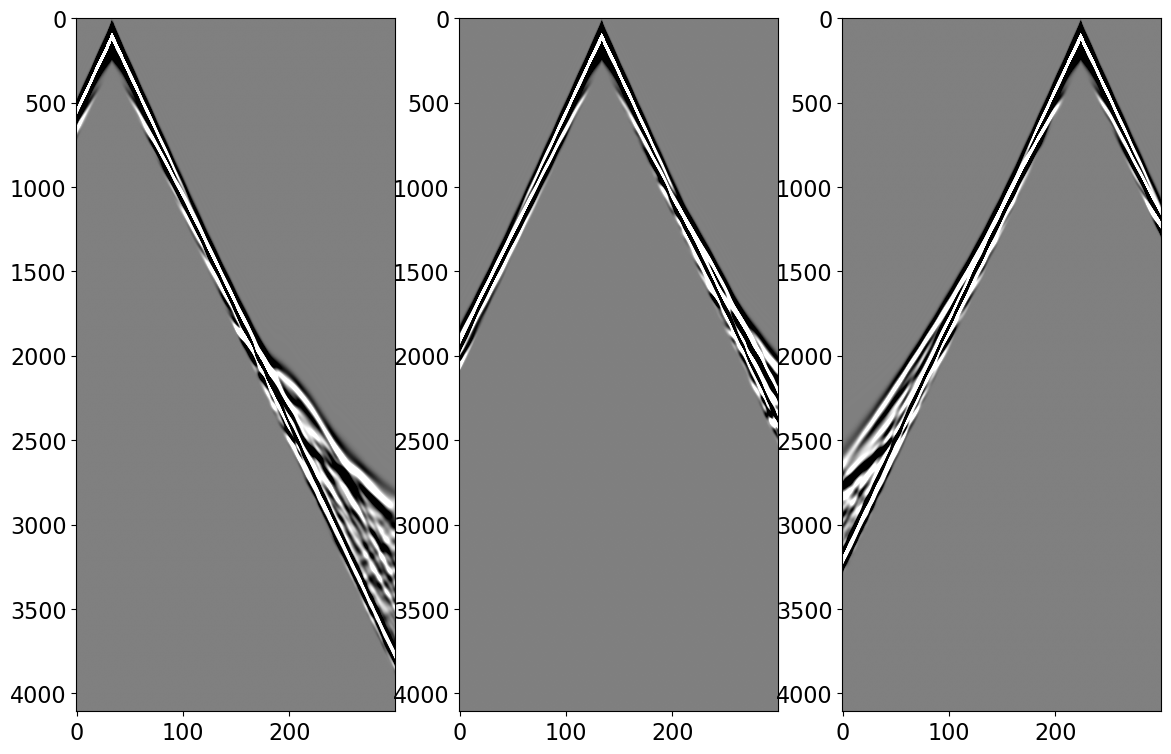

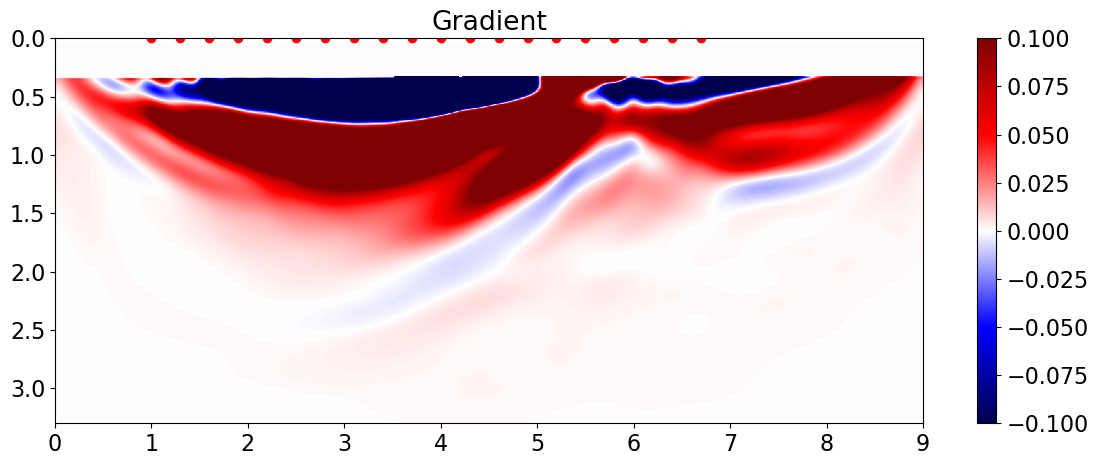

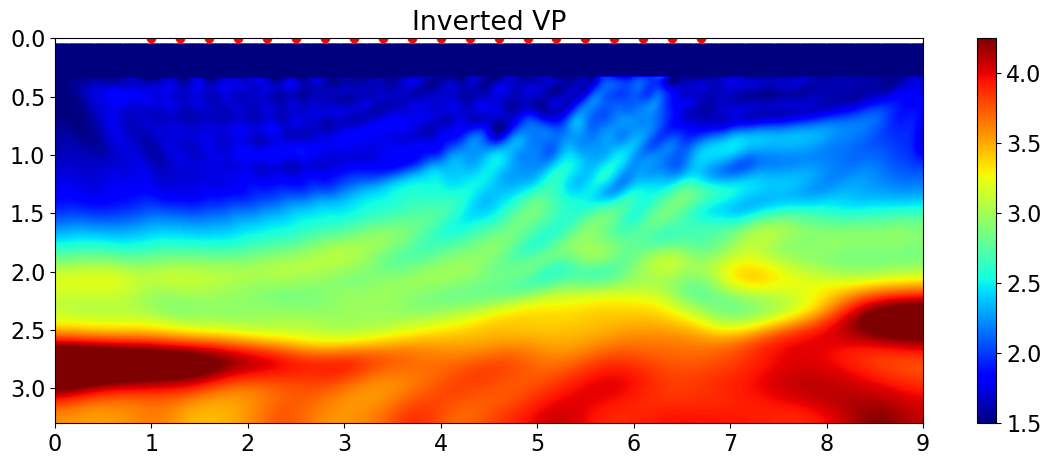

In [13]:
gamma = 1e3 # regularization parameter for SoftDTW
# Note that when the parameter normalize=True, the SoftDTW divergence is used.
# Also, the loss is computed on a time-subsampled version of the data (t_sub=5) to manage memory.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wav = geometry.src.wavelet
postprocess = PostProcessVP(scaling=1, mask=msk, sigmas=(4, 4))
vp_error_hist = []
afwi = AcousticFWI2D(par, vp_init=vp_init, vp_range=(vp_true.min(), vp_true.max()),
                     wav=1e6*wav, loss=SoftDTW, lossop=TSmaskop,
                     space_order=space_order, nbl=nbl, 
                     firstscaling=True, postprocess=postprocess, solver='L-BFGS-B',
                     kwargs_loss={'nr':par['nr'], 'nt':geometry.nt, 'gamma':gamma, 
                                  'normalize':True, 't_sub':5, 'device':device},
                     kwargs_solver={'ftol':0, 'gtol':0, 'maxiter':50, 'maxfun':200, 'disp':True},
                     callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error_hist))

vp_inv, loss_hist, nl = afwi.run(1e6*dobs_masked, plotflag=True)

In [14]:
nl

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 5.859603506896582
        x: [ 1.500e+00  1.500e+00 ...  4.088e+00  4.089e+00]
      nit: 50
      jac: [-0.000e+00 -0.000e+00 ...  2.003e-06  2.064e-06]
     nfev: 52
     njev: 52
 hess_inv: <132821x132821 LbfgsInvHessProduct with dtype=float64>

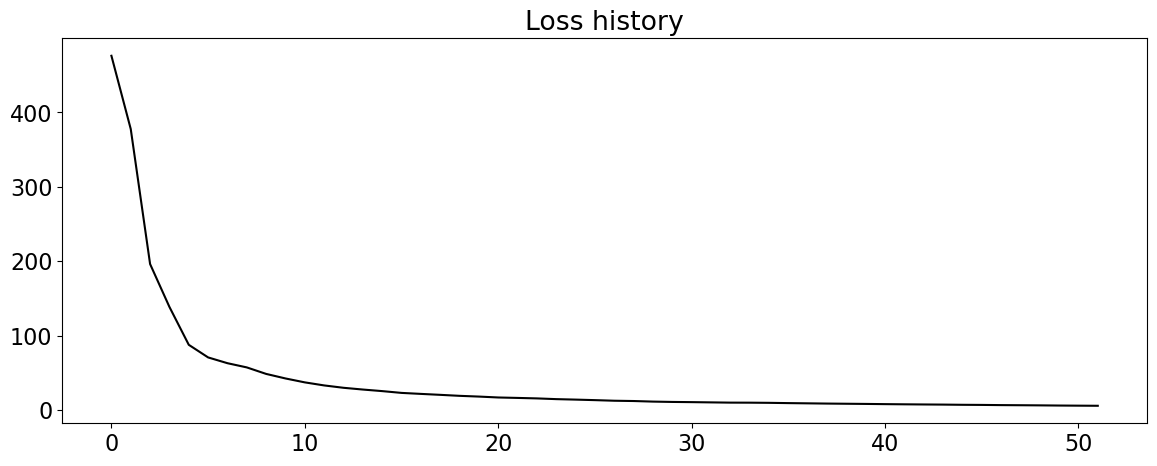

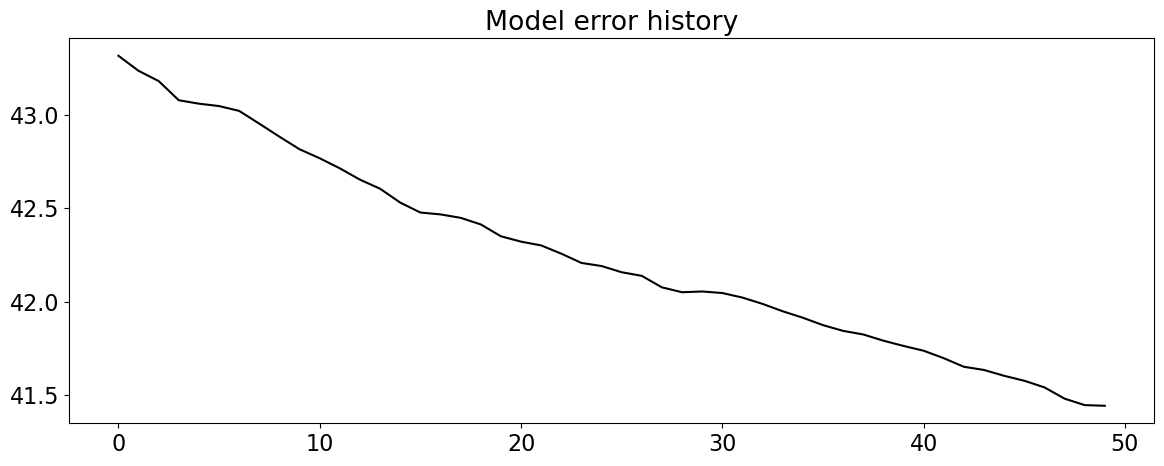

In [16]:
plt.figure(figsize=(14, 5))
plt.plot(list(chain.from_iterable(loss_hist)), 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error_hist, 'k')
plt.title('Model error history');

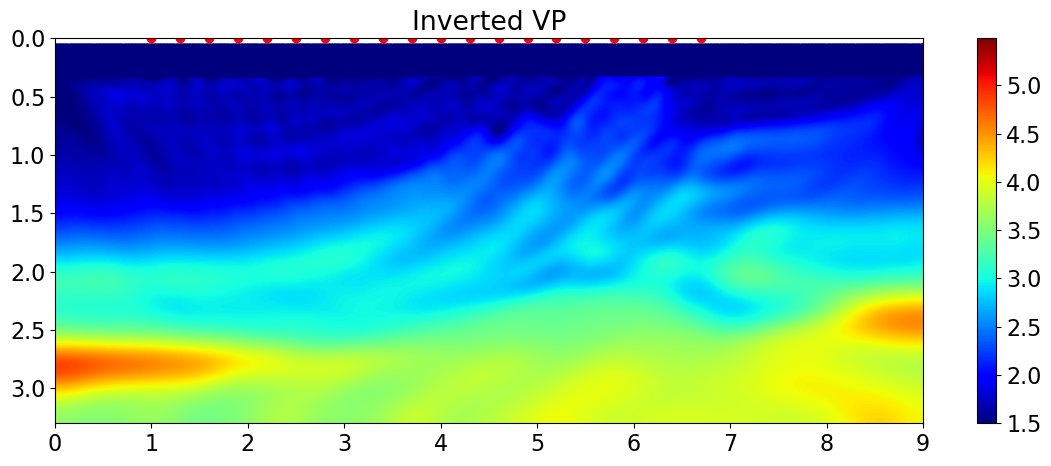

In [17]:
vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

In [18]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)

dinv = ainvfinal.mod_allshots(dt=geometry.dt)[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
# Mask predicted data
dinv_masked = np.hstack([(TSmaskop[isrc] @ dinv[isrc, :dobs.shape[1]].ravel())[None, :] for isrc in range(par['ns'])])
dinv_masked = dinv_masked.reshape(par['ns'], geometry.nt, par['nr'])

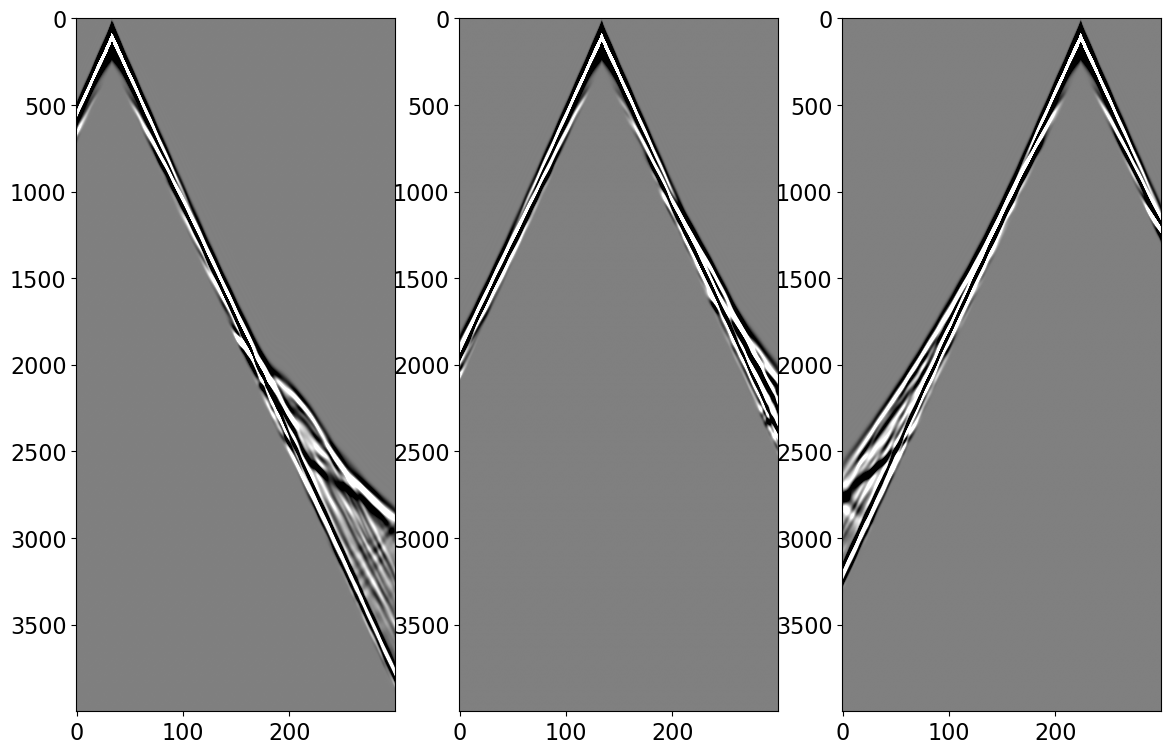

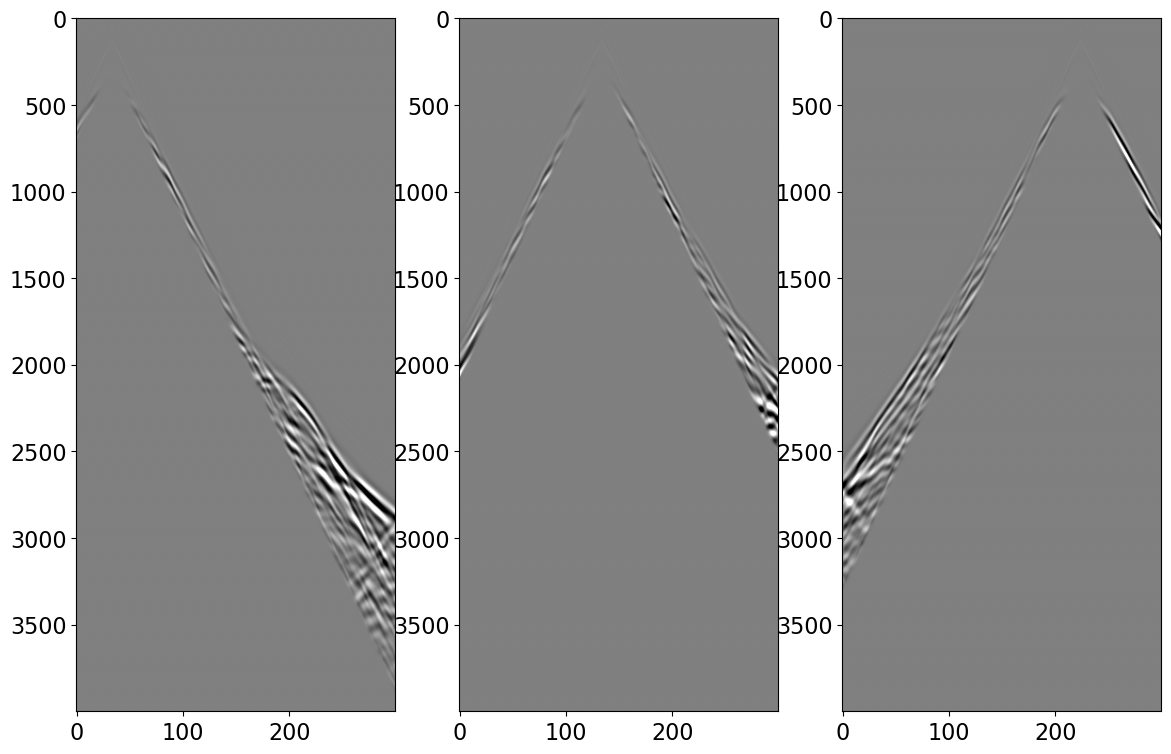

In [20]:
# Display modelling error
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot, :ntmax] - dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

In [ ]:
# Define loss (to which we add the mask as a diagonal linear operator applied to the modelled data)
gamma = 1e3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

softdtwloss = SoftDTW(TSmaskop, 1e6*dobs_masked.reshape(par['ns'], -1),
                       par['nr'], geometry.nt, gamma, normalize=True, device=device)

wav = geometry.src.wavelet
ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vprange=(vp_true.min(), vp_true.max()),
                      wav=1e6*wav, f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=softdtwloss);

# Compute first gradient and find scaling
postproc = PostProcessVP(scaling=1, mask=msk, sigmas=(4, 4))
loss, direction = ainv._loss_grad(vp_init, postprocess=postproc.apply)
print(loss)
scaling = direction.max()

plt.figure(figsize=(14, 5))
plt.imshow(direction.T / scaling, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient')
plt.axis('tight');

# FWI with L-BFGS
ftol = 0
gtol = 0
maxiter = 50
maxfun = 2000
vp_error = []
convertvp = None
scaling = 1
postproc = PostProcessVP(scaling=scaling, mask=msk)

nl = minimize(ainv.loss_grad, vp_init.ravel(), method='L-BFGS-B', jac=True,
              args=(convertvp, postproc.apply),
              callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error), 
              options={'ftol':ftol, 'gtol':gtol, 'maxiter':maxiter, 'maxfun':maxfun, 'disp':True})